# Tasks

- Task 1  [10 Points]: Work with [Amazon Fine Food Reviews dataset](https://www.kaggle.com/snap/amazon-fine-food-reviews)
    - Perform proper preprocessing and visualization
    - Perform proper hyperparameter tuning **-SVM-**. JUSTIFY ALL THE HYPERPARAMETER VALUES
    - **Hint**: Check [this](https://towardsdatascience.com/support-vector-machines-svm-c9ef22815589) tutorial and this [kernel](https://www.kaggle.com/laowingkin/amazon-fine-food-review-sentiment-analysis) for help 

* Task 2 (Bouns) [3 Points] : Follow [this tutorial](https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn) on **Naive Bayes** and apply what you learnt on the [Spam Classification dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset)



# **Task 1**

In [1]:
pip install vaderSentiment

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud
from sklearn.svm import SVC,LinearSVC
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from math import log2, sqrt

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Loading Data**

In [5]:
odf = pd.read_csv('Reviews.csv', nrows=5000)
odf['Helpful %'] = np.where(odf['HelpfulnessDenominator'] > 0, odf['HelpfulnessNumerator'] / odf['HelpfulnessDenominator'], -1)
odf['% Upvote'] = pd.cut(odf['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
odf.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty


# **EDA & Data preparation**

Text(0.5, 1.0, 'How helpful users find among user scores')

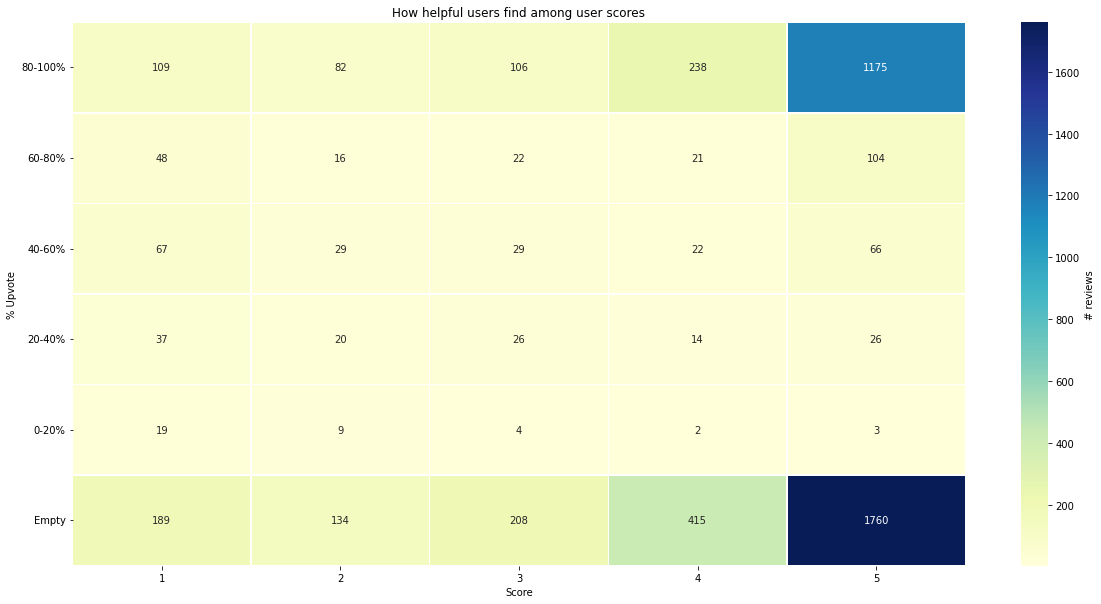

In [6]:
df_s = odf.groupby(['Score', '% Upvote']).agg({'Id': 'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1)
fig = plt.figure(figsize=(20,10))

sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = 'YlGnBu', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.yticks(rotation=0)
plt.title('How helpful users find among user scores')



*   There are more positive reviews than negative ones
*   The score 5 is the most common



**To apply SVM, we will separate the data into two clsses: Good -> 1 and Bad -> 0. The Neutral votes of 3 should be discarded as they don't add new information that would help us in the classification.**

In [7]:
df = odf[odf['Score'] != 3]
X = df['Text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['Score'].map(y_dict)

In [8]:
y

0       1
1       0
2       1
3       0
4       1
       ..
4994    1
4995    0
4996    0
4998    1
4999    1
Name: Score, Length: 4605, dtype: int64

In [9]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Score, dtype: int64

In [10]:
X.head()

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
Name: Text, dtype: object

Looking at the overall reviews:

5    62.68
4    14.24
1     9.38
3     7.90
2     5.80
Name: Score, dtype: float64


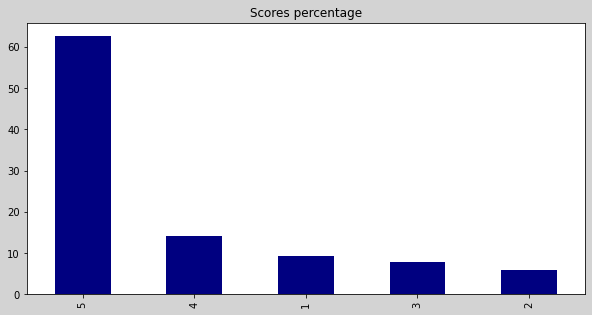

In [11]:
df_count_prcnt = odf.Score.value_counts()

def compute_percentage(x):
    pct = float(x/df_count_prcnt.sum()) * 100
    return round(pct, 2)

df_count_prcnt = df_count_prcnt.apply(compute_percentage)
fig = plt.figure(figsize=(10,5), facecolor='lightgray')
fig = plt.title('Scores percentage')

df_count_prcnt.plot(kind="bar", colormap='jet')

print(df_count_prcnt)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


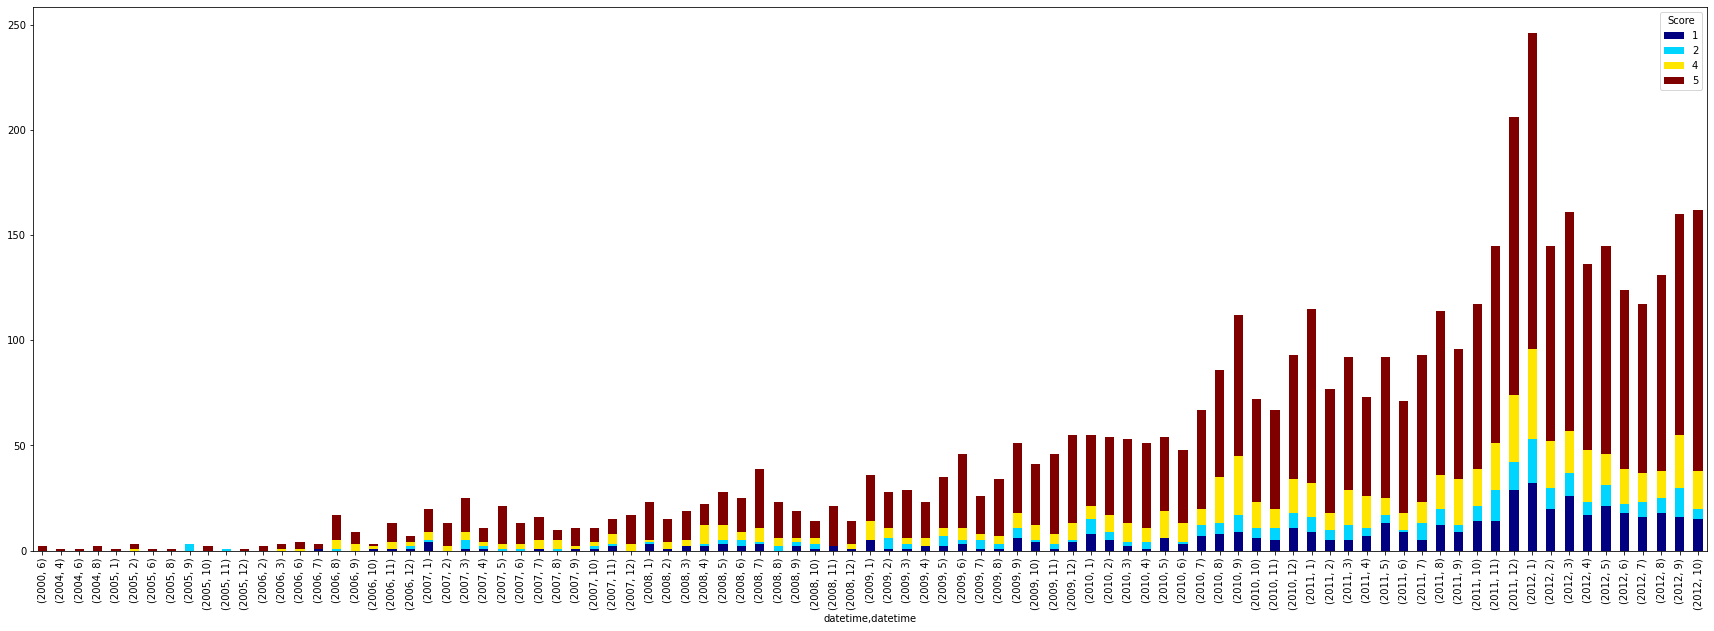

In [12]:
df['datetime'] = pd.to_datetime(df["Time"], unit='s')
df_grp = df.groupby([df.datetime.dt.year, df.datetime.dt.month, df.Score]).count()['ProductId'].unstack()

df_grp.plot(kind="bar",figsize=(30,10), stacked=True, colormap='jet')

In [13]:
pos = df.loc[df['Score'] > 3]

neg = df.loc[df['Score'] < 3]


In [14]:
def create_Word_Corpus(df):
    words_corpus = ''
    for val in pos["Summary"]:
        text = val.lower()
        #text = text.translate(trantab)
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        for words in tokens:
            words_corpus = words_corpus + words + ' '
    return words_corpus
        
# Generate a word cloud image
pos_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(pos))
neg_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(neg))

# Plot cloud
def plot_Cloud(wordCloud):
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    plt.savefig('wordclouds.png', facecolor='k', bbox_inches='tight')

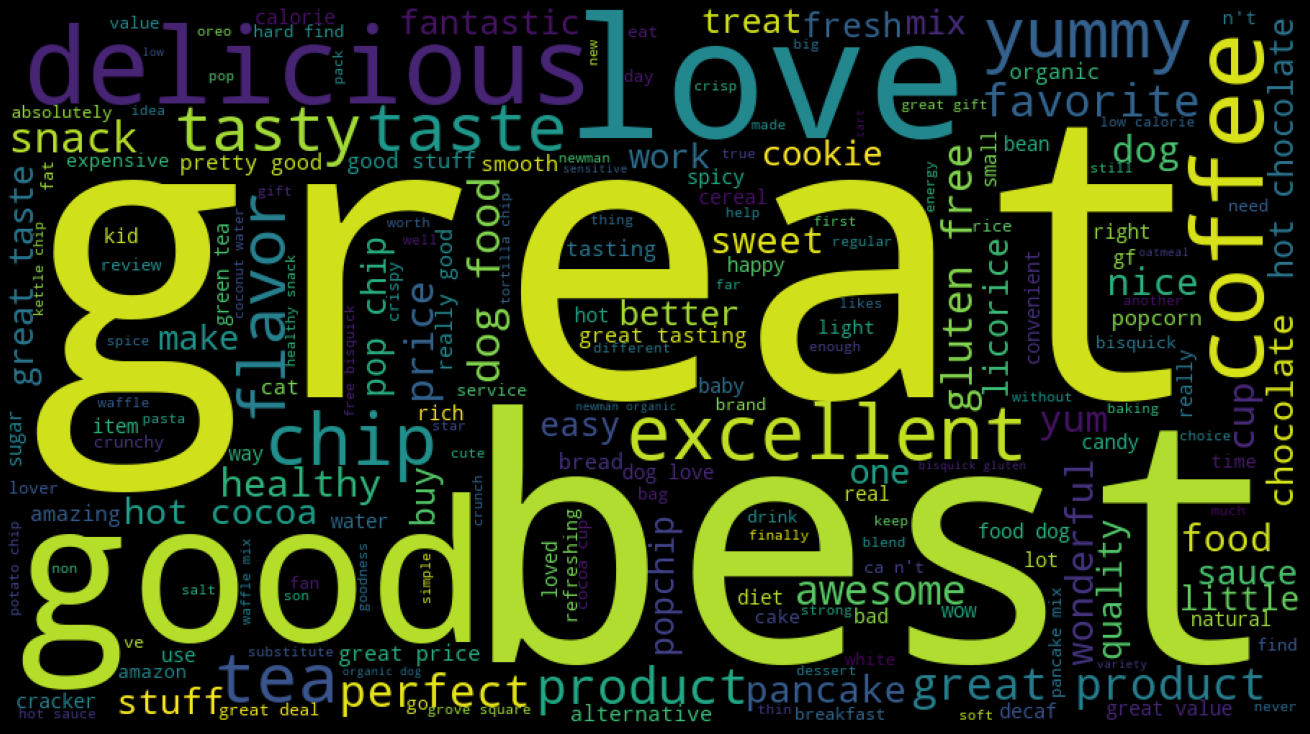

<Figure size 432x288 with 0 Axes>

In [15]:
plot_Cloud(pos_wordcloud)

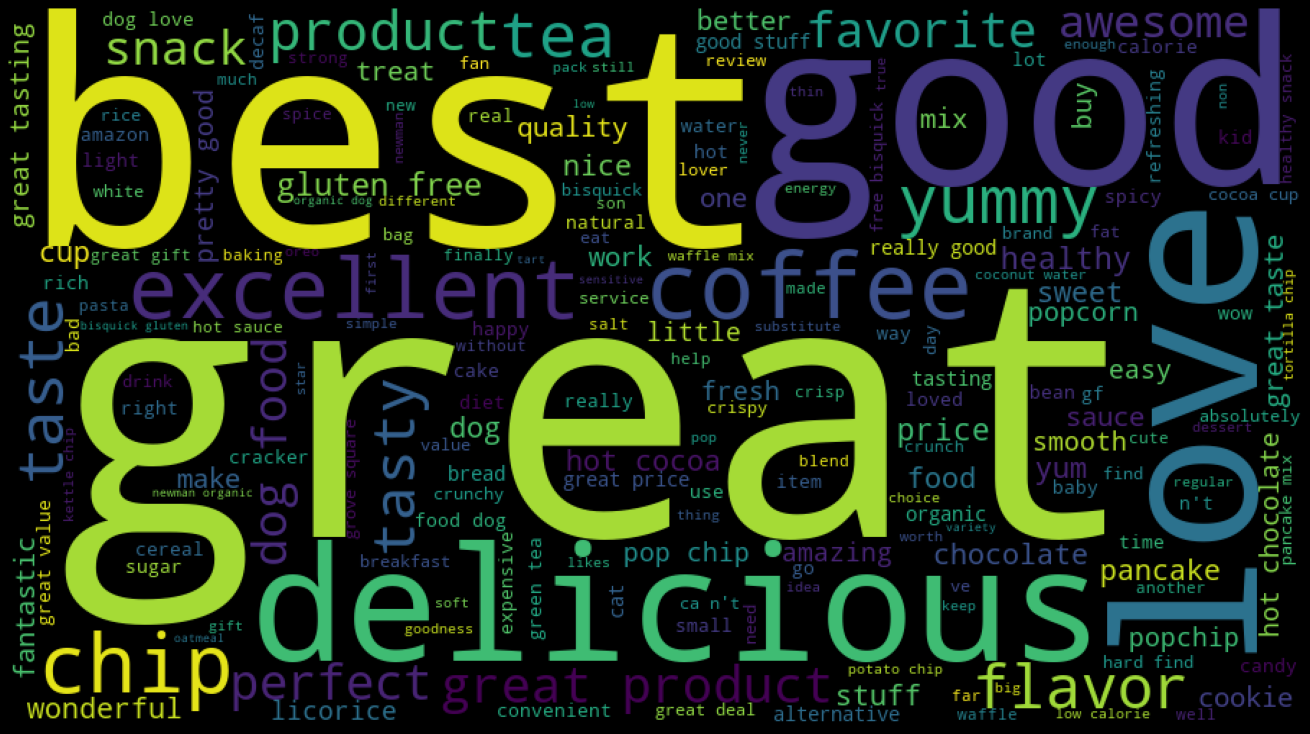

<Figure size 432x288 with 0 Axes>

In [16]:
plot_Cloud(neg_wordcloud)

The word cloud looks AMAZING! However, it only makes sense for the positive reviews. My explaination for that is that negative reviews probably share the same words with the positive ones except that they preceeded by words like 'not'.

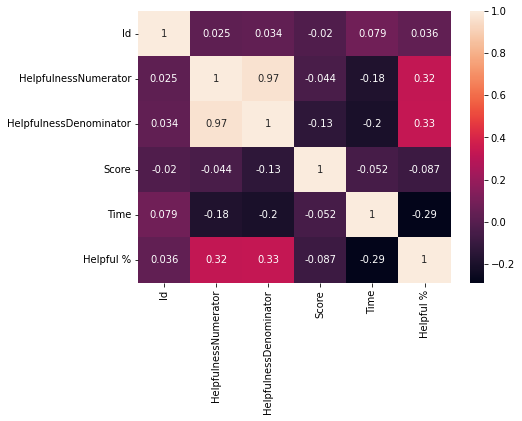

In [17]:
plt.figure(figsize = (7,5))
sns.heatmap(df.corr(), annot=True)
plt.show()

**Unnecessary features:**

1.   ID
2.   ProductId
3. UserId
4. ProfileName



In [18]:
df.drop(['Id','ProductId', 'UserId','ProfileName'], axis=1 , inplace= True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
df.tail()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote,datetime
4994,4,4,5,1322784000,AMAZING!,If you are on the paleo/caveman/primal/hunter-...,1.0,80-100%,2011-12-02
4995,1,1,2,1341273600,The cavemen must have been wealthy,I really wanted to like these.<br /><br />Firs...,1.0,80-100%,2012-07-03
4996,1,1,1,1341100800,These cookies need work; you can make your own...,I was not impressed with these cookies when I ...,1.0,80-100%,2012-07-01
4998,0,0,4,1342137600,"they are good (except for the ""rainforest"" fla...","These taste very good, but aren't like the BES...",-1.0,Empty,2012-07-13
4999,0,0,5,1337990400,Great Healthy Snack!,I love these cookies. I am on the paleo diet r...,-1.0,Empty,2012-05-26


# **Preprocessing**

In [20]:
df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote,datetime
0,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%,2011-04-27
1,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty,2012-09-07
2,1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%,2008-08-18
3,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%,2011-06-13
4,0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty,2012-10-21


Now, I will make the final modification on the dataset. I will add a target column that is either 1 or 0.

In [21]:
target = []

for j in range(len(df)):
    if df['Score'].iloc[j] < 3:
        result = 0
    else:
        result = 1
    target.append(result)

df['target'] = target

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [22]:
pd.DatetimeIndex(df['Time']).year.value_counts()

1970    4605
Name: Time, dtype: int64

In [23]:
df['Time']= pd.DatetimeIndex(df['Time']).year
df.rename(columns={'Time':'Year'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [24]:
df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Year,Summary,Text,Helpful %,% Upvote,datetime,target
0,1,1,5,1970,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%,2011-04-27,1
1,0,0,1,1970,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty,2012-09-07,0
2,1,1,4,1970,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%,2008-08-18,1
3,3,3,2,1970,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%,2011-06-13,0
4,0,0,5,1970,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty,2012-10-21,1


In [25]:
X=df.drop(['Score', 'target', 'HelpfulnessNumerator', 'HelpfulnessDenominator'], axis=1)
y=df['target']

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4605 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   HelpfulnessNumerator    4605 non-null   int64         
 1   HelpfulnessDenominator  4605 non-null   int64         
 2   Score                   4605 non-null   int64         
 3   Year                    4605 non-null   int64         
 4   Summary                 4605 non-null   object        
 5   Text                    4605 non-null   object        
 6   Helpful %               4605 non-null   float64       
 7   % Upvote                4605 non-null   category      
 8   datetime                4605 non-null   datetime64[ns]
 9   target                  4605 non-null   int64         
dtypes: category(1), datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 364.5+ KB


In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
X_dict = X.to_dict(orient='records') # turn each row as key-value pairs

X_dict

[{'% Upvote': '80-100%',
  'Helpful %': 1.0,
  'Summary': 'Good Quality Dog Food',
  'Text': 'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.',
  'Year': 1970,
  'datetime': Timestamp('2011-04-27 00:00:00')},
 {'% Upvote': 'Empty',
  'Helpful %': -1.0,
  'Summary': 'Not as Advertised',
  'Text': 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".',
  'Year': 1970,
  'datetime': Timestamp('2012-09-07 00:00:00')},
 {'% Upvote': '80-100%',
  'Helpful %': 1.0,
  'Summary': '"Delight" says it all',
  'Text': 'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. A

In [29]:
"""
from sklearn.feature_extraction import DictVectorizer
# instantiate a Dictvectorizer object for X
dv_X = DictVectorizer(sparse=False) 
# sparse = False makes the output is not a sparse matrix
"""

'\nfrom sklearn.feature_extraction import DictVectorizer\n# instantiate a Dictvectorizer object for X\ndv_X = DictVectorizer(sparse=False) \n# sparse = False makes the output is not a sparse matrix\n'

In [30]:
"""
X_encoded = dv_X.fit_transform(X_dict)
# show X_encoded
X_encoded
"""

'\nX_encoded = dv_X.fit_transform(X_dict)\n# show X_encoded\nX_encoded\n'

**I tried to encode using DictVectorizer but colab did not support that. I will discard this trial and work again from scratch on the data to find a feasible method to employ the textual data.**

**I will use Sentiment analyzer to give a score for the textual data and then drop the text and summary columns. I will then use label encoder for the categorical featuers.**

In [31]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyze = SentimentIntensityAnalyzer()

# scorer function based on cutoffs
def score_sentiment(compound_score):
    if compound_score >= 0.05:
        return("Positive")
    elif compound_score < 0.05 and compound_score >= -0.05:
        return("Neutral")
    else:
        return("Negative")

In [32]:
df["Text_score"] = df["Text"].map(lambda x: score_sentiment(analyze.polarity_scores(x)['compound']))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
df["Summary"] = df["Summary"].fillna('')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
df["Summary_score"] = df["Summary"].map(lambda x: score_sentiment(analyze.polarity_scores(x)['compound']))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
df.drop(['Text','Summary'], axis=1 , inplace= True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4605 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   HelpfulnessNumerator    4605 non-null   int64         
 1   HelpfulnessDenominator  4605 non-null   int64         
 2   Score                   4605 non-null   int64         
 3   Year                    4605 non-null   int64         
 4   Helpful %               4605 non-null   float64       
 5   % Upvote                4605 non-null   category      
 6   datetime                4605 non-null   datetime64[ns]
 7   target                  4605 non-null   int64         
 8   Text_score              4605 non-null   object        
 9   Summary_score           4605 non-null   object        
dtypes: category(1), datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 364.5+ KB


In [37]:
cat_cols = df.columns[(df.dtypes =='object').values].tolist()
cat_cols

['Text_score', 'Summary_score']

In [38]:
from sklearn.preprocessing import LabelEncoder

In [39]:
summary = df.iloc[:,-1]
Summary_encoder = LabelEncoder()
summary = Summary_encoder.fit_transform(summary)
df.iloc[:,-1]=summary

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [40]:
text=df.iloc[:,-2]
text_encoder = LabelEncoder()
text = text_encoder.fit_transform(text)
df.iloc[:,-2]=text

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [41]:
df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Year,Helpful %,% Upvote,datetime,target,Text_score,Summary_score
0,1,1,5,1970,1.0,80-100%,2011-04-27,1,2,2
1,0,0,1,1970,-1.0,Empty,2012-09-07,0,0,1
2,1,1,4,1970,1.0,80-100%,2008-08-18,1,2,2
3,3,3,2,1970,1.0,80-100%,2011-06-13,0,2,1
4,0,0,5,1970,-1.0,Empty,2012-10-21,1,2,2


In [42]:
X=df.drop(['Score', 'target', 'HelpfulnessNumerator', 'HelpfulnessDenominator', '% Upvote', 'datetime'], axis=1)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
y=df['target']

# **Modeling**

# **Applying default SVM**

In [43]:
model = SVC() 
model.fit(X_train,y_train)
y_predic=model.predict(X_test)
print('Accuracy Score for default parameters:')
print(metrics.accuracy_score(y_test,y_predic))

Accuracy Score for default parameters:
0.8957654723127035


In [44]:
print(classification_report(y_test, y_predic, target_names=['Negative','Positive']))
print("Accuracy :",accuracy_score(y_test, y_predic), end='\n\n')
conf_mat = confusion_matrix(y_test, y_predic)
print(conf_mat)

              precision    recall  f1-score   support

    Negative       0.75      0.58      0.65       156
    Positive       0.92      0.96      0.94       765

    accuracy                           0.90       921
   macro avg       0.83      0.77      0.80       921
weighted avg       0.89      0.90      0.89       921

Accuracy : 0.8957654723127035

[[ 91  65]
 [ 31 734]]


# **Hyperparameter tuning - Linear kernal**

[0.8892553994152598, 0.8955474865604074, 0.8920715835141, 0.8961958879562388, 0.8981505234367632, 0.8903343393379233, 0.8931552390832784, 0.8925054229934923, 0.8938088276902765, 0.8864307271526926, 0.8922955767235686, 0.8914245968122231, 0.8879482222012637, 0.8944600584740167, 0.8942506837687448, 0.8925134395925681, 0.8912090917664811, 0.8979336036970667, 0.8914222389889656, 0.8957705366405735, 0.8890347071583514, 0.8894661888144866, 0.8905602188059983, 0.8938102423842308, 0.8968471187399792, 0.890769121946619, 0.8951127039517118, 0.8974992926530228, 0.8961996604734509]


Text(0, 0.5, 'Cross-Validation Accuracy')

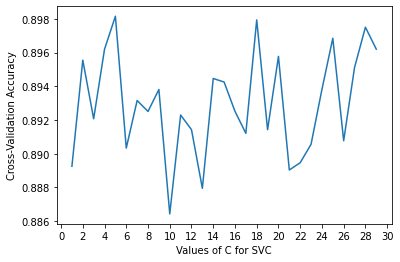

In [45]:
C_range=list(range(1,30))
acc_scores=[]
for c in C_range:
    model = SVC(kernel='linear', C=c)
    scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    acc_scores.append(scores.mean())

print(acc_scores)    
plt.plot(C_range,acc_scores)
plt.xticks(np.arange(0,31,2))
plt.xlabel('Values of C for SVC')
plt.ylabel('Cross-Validation Accuracy')

# **Hyperparameter tuning - RBF kernal**

[0.8890375365462605, 0.8953324530793173, 0.8983702725643686, 0.899672262567198, 0.8992384230878054, 0.899673205696501, 0.9005408846552865, 0.9001061020465906, 0.8996727341318496, 0.8998901254361975, 0.9001079883051967, 0.9016273696123738, 0.9016273696123738, 0.9005404130906347, 0.901409035178723]


Text(0, 0.5, 'Cross-Validated Accuracy')

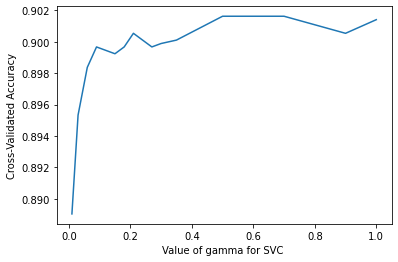

In [46]:
gamma_range=[0.01, 0.03,0.06,0.09,0.15,0.18,0.21,0.24,0.27,0.3, 0.35, 0.5, 0.7, 0.9, 1]
acc_scores=[]
for g in gamma_range:
    model = SVC(kernel='rbf', gamma=g)
    scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    acc_scores.append(scores.mean())
print(acc_scores)    
# plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(gamma_range,acc_scores)
plt.xlabel('Value of gamma for SVC ')
plt.ylabel('Cross-Validated Accuracy')

# **Grid Search**

In [47]:
grid_params = {
        'C':  (np.arange(0.1,1,0.1)),
        'gamma':[0.2,0.22,0.24,0.26,0.28],
        "kernel":[ 'rbf', 'linear']
}
svm_model= SVC()

model_svm = GridSearchCV(svm_model, grid_params,cv=10,scoring='accuracy')
model_svm.fit(X_train, y_train)
print(model_svm.best_score_)
print(model_svm.best_score_)
print(model_svm.best_params_)

0.9011812183339225
0.9011812183339225
{'C': 0.2, 'gamma': 0.22, 'kernel': 'rbf'}


In [48]:
y_pred= model_svm.predict(X_test)
print(metrics.accuracy_score(y_pred,y_test))

0.8957654723127035


# **The Bonus task is submitted in a separate notebook.**